In [102]:
import numpy as np
import matplotlib.pyplot as plt
import cma
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

# Finding Best Model

## Defining Model Curves

### Pruning vs Accuracy

In [132]:
def get_accuracy(p):
    #6th order polynomial coefficients
    coeffs = [85.28, -10.35, -28.44, -49.40]
    
    acc = sum(c * p**i for i, c in enumerate(coeffs))

    return max(acc, 0)

### Pruning vs Model Size

In [133]:
def get_size(p):
    coeffs = [496.7, -706.2, 276.9, 4.020]
    
    return sum(c * p**i for i, c in enumerate(coeffs))

### Pruning vs Inference Time

In [134]:
def get_time(p):
    b0 = 0.06386
    b1 = -0.06386
    
    return (b0 + b1 * p)*10

In [135]:
p = 0.1
get_accuracy(p), get_size(p), get_time(p)

(83.91120000000001, 428.85301999999996, 0.57474)

In [136]:
def normalize(arr):
    min_element = min(arr)
    max_element = max(arr)
    return [(x - min_element) / (max_element - min_element) for x in arr]

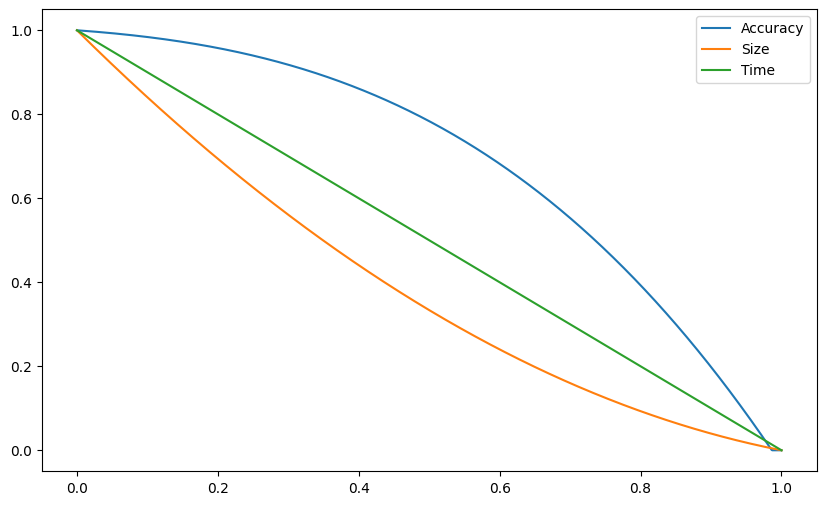

In [137]:
pruning_amounts = np.arange(0.0, 1.001, 0.001)
plt.figure(figsize=(10, 6))
accuracies = [get_accuracy(p) for p in pruning_amounts]
sizes = [get_size(p) for p in pruning_amounts]
times = [get_time(p) for p in pruning_amounts]

plt.plot(pruning_amounts, normalize(accuracies), label='Accuracy')
plt.plot(pruning_amounts, normalize(sizes), label='Size')
plt.plot(pruning_amounts, normalize(times), label='Time')
plt.legend()

#$ Defining Rewards

### Accuracy Reward

In [138]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return (np.exp(- (diff**2) / (10 * sigma_left**2)) * 100)
    else:
        return 1*(np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100)

In [139]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
acc_rewards = []
accuracies = []
pruning_amounts = np.arange(0.0, 1.001, 0.001)
for p in pruning_amounts:
    accuracy = get_accuracy(p)
    reward = get_accuracy_reward(accuracy, min_accuracy=80)
    accuracies.append(accuracy)
    acc_rewards.append(reward)

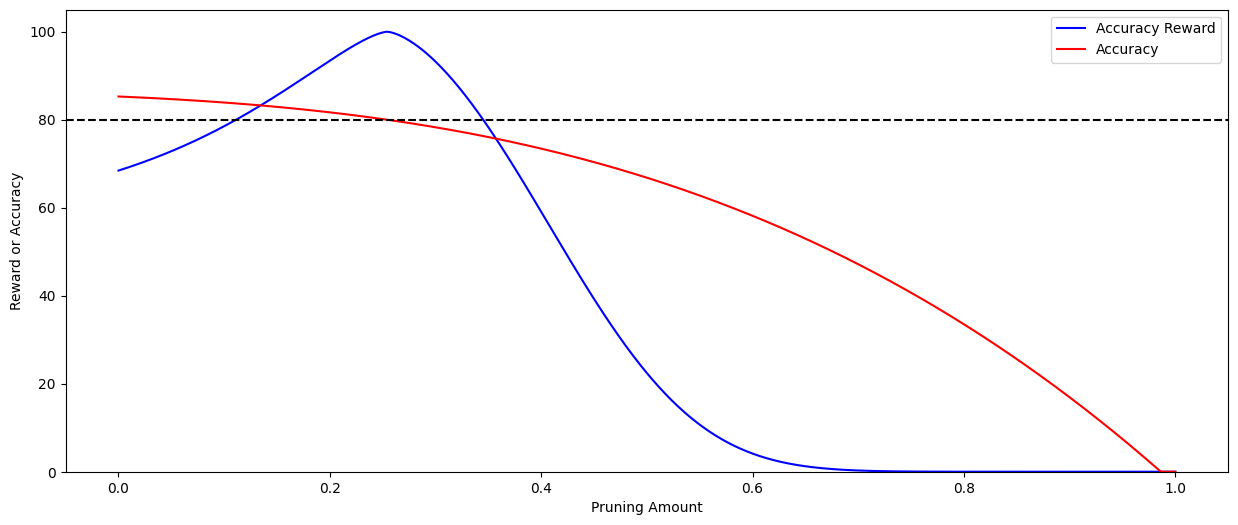

In [140]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, acc_rewards, label='Accuracy Reward', color='blue')
plt.plot(pruning_amounts, accuracies, label='Accuracy', color='red')
plt.ylim(0)
plt.axhline(y=80, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Accuracy')
plt.legend()

### Inference Time Reward

In [141]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*10

In [142]:
time_rewards = []
comp_times = []
for p in pruning_amounts:
    time = get_time(p)
    reward = get_comp_time_reward(time)
    comp_times.append(time)
    time_rewards.append(reward)

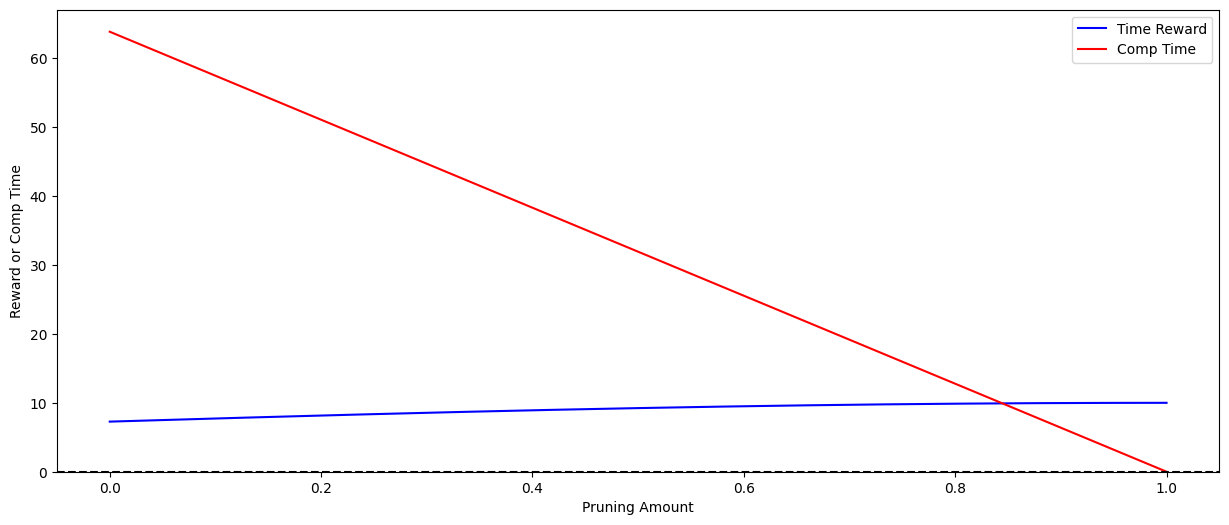

In [143]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, time_rewards, label='Time Reward', color='blue')
plt.plot(pruning_amounts, [x * 100 for x in comp_times], label='Comp Time', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Comp Time')
plt.legend()

### Model Size Reward

In [144]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- ((diff)**2) / (10 * sigma_left**2))*99*0.5
    if current_model_size == max_model_size:
        return 99*(0.5)
    else:
        return (99+(current_model_size/max_model_size))*0.5

In [145]:
size_rewards = []
sizes = []
# max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)
for p in pruning_amounts:
    size = get_size(p)
    reward = get_model_size_reward(size, max_model_size=300)
    sizes.append(size)
    size_rewards.append(reward)

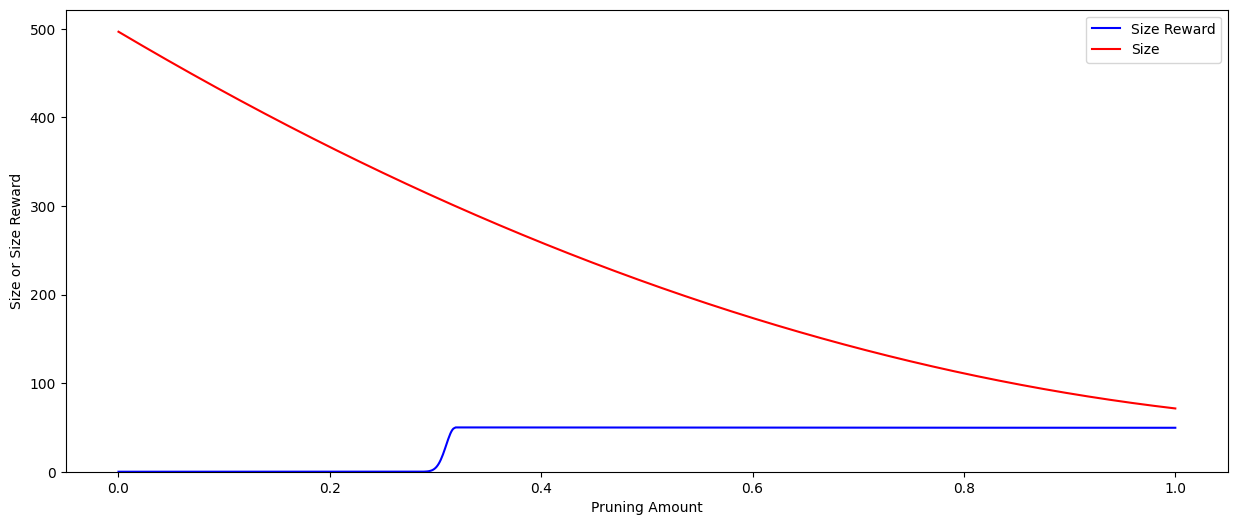

In [146]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, size_rewards, label='Size Reward', color='blue')
plt.plot(pruning_amounts, sizes, label='Size', color='red')
plt.ylim(0)
plt.xlabel('Pruning Amount')
plt.ylabel('Size or Size Reward')
plt.legend()

### Reward for better pruning

In [147]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

In [148]:
counts_of_calulating_rewards = 0

### Final Reward Calculation

In [149]:
def get_reward(p, min_accuracy=80.0, max_model_size=350.0, x=10, y=1, z=1) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    global counts_of_calulating_rewards
    counts_of_calulating_rewards += 1 # type: ignore
    
    x, y, z = x/(x+y+z), y/(x+y+z), z/(x+y+z)
    
    return (x*acc_reward + y*time_reward + z*size_reward + better_reward + p/2)

In [150]:
def get_details(p,min_accuracy, max_model_size):
    return {
        'Min Accuracy Required': min_accuracy,
        'Max Model Size Required': max_model_size,
        'Pruning Amount': p,
        "Accuracy": get_accuracy(p),
        "Time": get_time(p),
        "Size": get_size(p),
        "Accuracy Reward": get_accuracy_reward(get_accuracy(p), min_accuracy),
        "Time Reward": get_comp_time_reward(get_time(p)),
        "Size Reward": get_model_size_reward(get_size(p), max_model_size),
        "More Acc Less Size Reward": more_acc_less_size(get_accuracy(p), min_accuracy, get_size(p), max_model_size),
        "Pruning Reward": p * 100,
        "Total Reward": get_reward(p),
    }

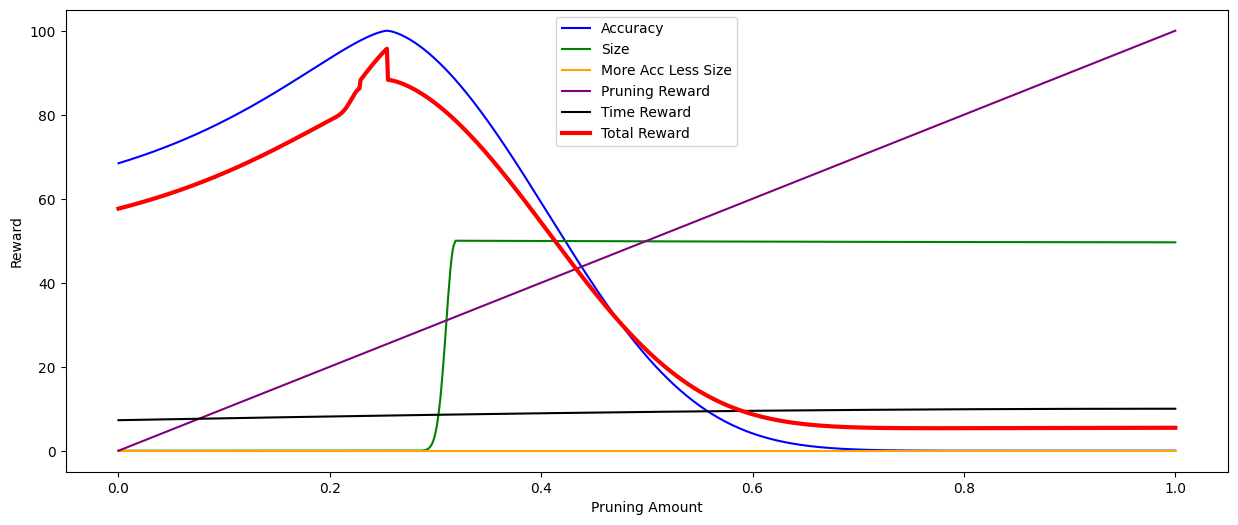

In [151]:
pruning_amounts = np.arange(0.0, 1.001, 0.001)
min_accuracy = 80.0
max_model_size = 300.0
results = [get_details(p, min_accuracy, max_model_size) for p in pruning_amounts]

plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, [r['Accuracy Reward'] for r in results], label='Accuracy', color='blue')
plt.plot(pruning_amounts, [r['Size Reward'] for r in results], label='Size', color='green')
plt.plot(pruning_amounts, [r['More Acc Less Size Reward'] for r in results], label='More Acc Less Size', color='orange')
plt.plot(pruning_amounts, [r['Pruning Reward'] for r in results], label='Pruning Reward', color='purple')
plt.plot(pruning_amounts, [r['Time Reward'] for r in results], label='Time Reward', color='black')
plt.plot(pruning_amounts, [r['Total Reward'] for r in results], label='Total Reward', color='red', linewidth=3)
plt.xlabel('Pruning Amount')
plt.ylabel('Reward')
plt.legend()

## Global Optimization with CMA-ES
Here we apply the CMA-ES evolutionary strategy for robust, gradient-free maximization of the total reward over the pruning amount.

In [152]:
def get_best_pruning_amount(min_accuracy=80.0, max_model_size=300.0):
    def objective(x):
        p = x[0]
        return -1 * get_reward(p, min_accuracy=min_accuracy, max_model_size=max_model_size) 

    x0 = [0.1, 0.0]
    sigma = 0.2
    bounds = [[0.0, -float('inf')], [1.0, float('inf')]]

    es = cma.CMAEvolutionStrategy(x0, sigma, {
        'bounds': bounds,
        'popsize': 20,
        'CMA_diagonal': 0
    })

    for _ in range(100):
        candidates = es.ask()
        fitnesses = [objective(c) for c in candidates]
        es.tell(candidates, fitnesses)

    opt_p = es.result.xbest[0]
    # print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")
    # print(f"Maximum reward: {-es.result.fbest:.4f}")
    # print(f"Number of reward calculations: {counts_of_calulating_rewards}") # type: ignore
    return opt_p.item()

In [153]:
rewards = [get_reward(p) for p in pruning_amounts]
max_index = np.argmax(rewards)
max_reward = rewards[max_index]

In [154]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)

In [155]:
opt_p = get_best_pruning_amount(min_accuracy=min_accuracy, max_model_size=max_model_size)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=420817, Sat Jul 12 11:48:26 2025)
NOTE (module=cma, iteration=22):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.9e+07 to 1.4e+00


In [156]:
print(opt_p)

0.25419732278810514


In [157]:
get_details(opt_p, min_accuracy=min_accuracy, max_model_size=max_model_size)

{'Min Accuracy Required': 80.0,
 'Max Model Size Required': 300.0,
 'Pruning Amount': 0.25419732278810514,
 'Accuracy': 79.99996165252637,
 'Time': 0.4762695896675161,
 'Size': 335.14412792408484,
 'Accuracy Reward': np.float64(99.99999925791244),
 'Time Reward': np.float64(8.376013027457958),
 'Size Reward': np.float64(1.9256250125616186e-12),
 'More Acc Less Size Reward': 0,
 'Pruning Reward': 25.419732278810514,
 'Total Reward': np.float64(88.32333057240974)}

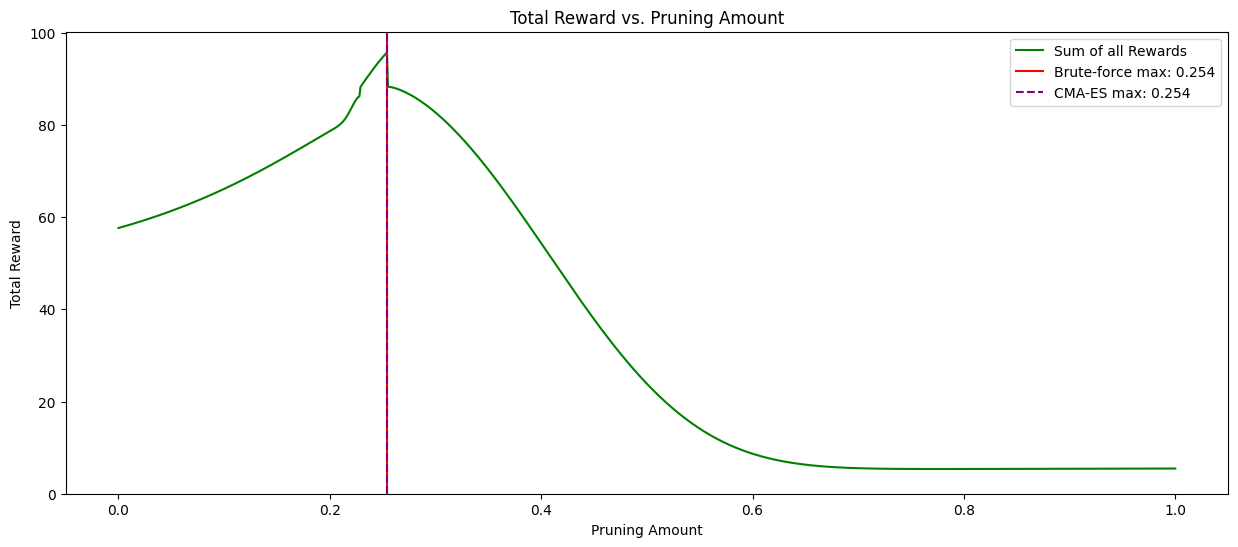

Brute-force search optimal pruning amount: 0.2540
CMA-ES found optimal pruning amount: 0.2542
Reward at brute-force optimum: 95.71
Reward at CMA-ES optimum: 88.32


In [158]:
# Plotting the results to compare brute-force and CMA-ES
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, rewards, label='Sum of all Rewards', color='green')

# Brute-force result
brute_force_p = pruning_amounts[max_index]
plt.axvline(x=brute_force_p, color='red', linestyle='-', label=f'Brute-force max: {brute_force_p:.3f}')

# CMA-ES result
plt.axvline(x=opt_p, color='purple', linestyle='--', label=f'CMA-ES max: {opt_p:.3f}')

plt.ylim(0)
plt.xlabel('Pruning Amount')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Pruning Amount')
plt.legend()
plt.show()

print(f"Brute-force search optimal pruning amount: {brute_force_p:.4f}")
print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")

# Also print the rewards at these points
reward_brute_force = get_reward(brute_force_p)
reward_cma_es = get_reward(opt_p)

print(f"Reward at brute-force optimum: {reward_brute_force:.2f}")
print(f"Reward at CMA-ES optimum: {reward_cma_es:.2f}")

In [159]:
get_details(brute_force_p, min_accuracy=min_accuracy, max_model_size=max_model_size)

{'Min Accuracy Required': 80.0,
 'Max Model Size Required': 300.0,
 'Pruning Amount': np.float64(0.254),
 'Accuracy': np.float64(80.0067439984),
 'Time': np.float64(0.4763956),
 'Size': np.float64(335.25555639728),
 'Accuracy Reward': np.float64(99.99988629627859),
 'Time Reward': np.float64(8.375227514301754),
 'Size Reward': np.float64(1.5827080941089333e-12),
 'More Acc Less Size Reward': 0,
 'Pruning Reward': np.float64(25.4),
 'Total Reward': np.float64(95.70879538034555)}

# Finding Initial Importance of Views

In [81]:
delta_single_view = np.array(
    [18.15, 12.55, 8.79, 10.09, 11.37, 14.52, 10.85, 12.94, 15.52, 9.79, 8.49, 7.62])

delta_drop_view = np.array(
    [0.32, 0.16, 0.63, 0.57, 0.32, 0.07, 0.22, 0.07, 0.51, 0.87, 1.17, 0.78])

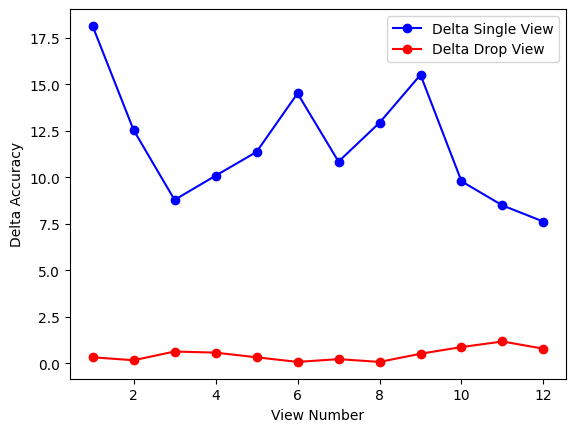

In [82]:
plt.plot(range(1, 13), delta_single_view, marker='o', color='blue', label='Delta Single View')
plt.plot(range(1, 13), delta_drop_view, marker='o', color='red', label='Delta Drop View')
plt.xlabel('View Number')
plt.ylabel('Delta Accuracy')
plt.legend()

$$ i \propto acc_{drop} $$
$$ \text{and} $$
$$ i \propto \frac {1} {acc_{view}} $$

$$ i \propto \frac {acc_{drop}} {acc_{view}}

In [ ]:
i = (delta_drop_view/delta_single_view)/np.sum(delta_drop_view/delta_single_view)

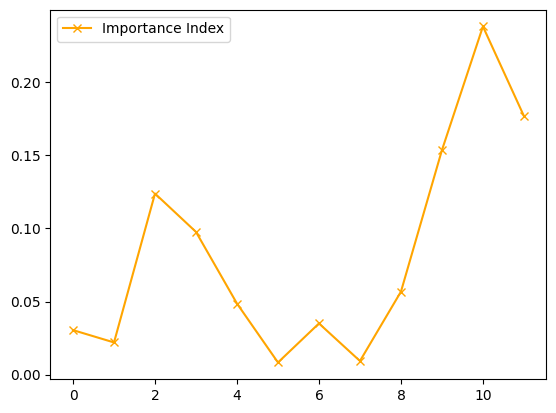

In [84]:
plt.plot(range(0, 12), i, marker='x', color='orange', label='Importance Index')
plt.legend()

# Per View Accuracy

Assuming $acc_f = \sum_{v=0}^v acc_m \cdot i_v$

In [85]:
whole_model_accuracy = 85.01

In [86]:
per_view_acc_req = whole_model_accuracy*i

In [87]:
per_view_acc_req, sum(per_view_acc_req)

(array([ 2.5881814 ,  1.87153356, 10.521388  ,  8.29287371,  4.13152967,
         0.70770585,  2.97655769,  0.79411816,  4.82391694, 13.04541571,
        20.23017006, 15.02660926]),
 np.float64(85.01))

In [88]:
def get_pruning_from_accuracy(target_acc):
    """Inverse function to find pruning amount for a target accuracy"""
    # Using Newton-Raphson method to solve for p given target accuracy
    p = 0.1  # initial guess
    for _ in range(100):  # max iterations
        current_acc = get_accuracy(p)
        if abs(current_acc - target_acc) < 1e-6:
            break
        
        # Calculate derivative numerically
        eps = 1e-8
        acc_plus = get_accuracy(p + eps)
        acc_minus = get_accuracy(p - eps)
        derivative = (acc_plus - acc_minus) / (2 * eps)
        
        if abs(derivative) < 1e-10:  # avoid division by zero
            break
            
        # Newton-Raphson update
        p = p - (current_acc - target_acc) / derivative
        p = max(0.0, min(1.0, p))  # clamp to valid range
    
    return p

def calculate_per_view_reward(per_view_accuracies, min_accuracy=80.0, max_model_size=300.0):
    """Calculate total reward for per-view accuracy distribution"""
    total_reward = 0.0
    
    for view_idx, view_acc in enumerate(per_view_accuracies):
        # Ensure minimum accuracy constraint
        if view_acc < min_accuracy:
            return -1000  # Heavy penalty for violating constraints
        
        # Calculate pruning amount for this view's target accuracy
        p_view = get_pruning_from_accuracy(view_acc)
        
        # Calculate individual view reward
        view_reward = get_reward(p_view, min_accuracy, max_model_size)
        total_reward += view_reward * i[view_idx]  # Weight by importance
    
    return total_reward

def optimize_per_view_accuracies(min_accuracy=80.0, max_model_size=300.0, target_total_acc=85.01):
    """Use CMA-ES to optimize per-view accuracy distribution"""
    
    def objective(x):
        # x contains 12 per-view accuracies
        per_view_accs = np.array(x)
        
        # Constraint: weighted sum should equal target total accuracy
        weighted_sum = np.sum(per_view_accs * i)
        constraint_penalty = abs(weighted_sum - target_total_acc) * 100
        
        # Calculate reward
        reward = calculate_per_view_reward(per_view_accs, min_accuracy, max_model_size)
        
        # Return negative for minimization (CMA-ES minimizes)
        return -(reward - constraint_penalty)
    
    # Initial guess: start with minimum accuracy for all views
    x0 = [min_accuracy + 5.0] * 12  # slightly above minimum
    sigma = 2.0  # standard deviation for initial search
    
    # Bounds: format as [lower_bounds, upper_bounds]
    lower_bounds = [min_accuracy] * 12
    upper_bounds = [100.0] * 12
    bounds = [lower_bounds, upper_bounds]
    
    es = cma.CMAEvolutionStrategy(x0, sigma, {
        'bounds': bounds,
        'popsize': 50,  # larger population for multi-dimensional problem
        'maxiter': 200,
        'tolfun': 1e-6
    })
    
    best_solution = None
    best_reward = -float('inf')
    
    while not es.stop():
        candidates = es.ask()
        fitnesses = [objective(c) for c in candidates]
        es.tell(candidates, fitnesses)
        
        # Track best solution
        current_best_idx = np.argmin(fitnesses)
        current_best_reward = -fitnesses[current_best_idx]
        
        if current_best_reward > best_reward:
            best_reward = current_best_reward
            best_solution = candidates[current_best_idx]
    
    return np.array(best_solution), best_reward

# Run the optimization
print("Optimizing per-view accuracies using CMA-ES...")
optimal_per_view_accs, optimal_reward = optimize_per_view_accuracies(
    min_accuracy=min_accuracy, 
    max_model_size=max_model_size, 
    target_total_acc=whole_model_accuracy
)

print(f"\nOptimal per-view accuracies:")
for i_view, acc in enumerate(optimal_per_view_accs):
    print(f"View {i_view + 1}: {acc:.2f}%")

print(f"\nWeighted sum accuracy: {np.sum(optimal_per_view_accs * i):.2f}%")
print(f"Target accuracy: {whole_model_accuracy:.2f}%")
print(f"Total reward: {optimal_reward:.2f}")

# Calculate corresponding pruning amounts
optimal_pruning_amounts = [get_pruning_from_accuracy(acc) for acc in optimal_per_view_accs]
print("\nCorresponding pruning amounts:")
for i_view, p in enumerate(optimal_pruning_amounts):
    print(f"View {i_view + 1}: {p:.4f}")

Optimizing per-view accuracies using CMA-ES...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 12 (seed=399606, Sat Jul 12 03:22:56 2025)

Optimal per-view accuracies:
View 1: 85.01%
View 2: 85.01%
View 3: 85.02%
View 4: 85.00%
View 5: 85.00%
View 6: 85.06%
View 7: 85.01%
View 8: 85.00%
View 9: 85.01%
View 10: 85.01%
View 11: 85.01%
View 12: 85.01%

Weighted sum accuracy: 85.01%
Target accuracy: 85.01%
Total reward: 83.96

Corresponding pruning amounts:
View 1: 0.0248
View 2: 0.0245
View 3: 0.0232
View 4: 0.0252
View 5: 0.0249
View 6: 0.0203
View 7: 0.0246
View 8: 0.0248
View 9: 0.0245
View 10: 0.0245
View 11: 0.0244
View 12: 0.0245


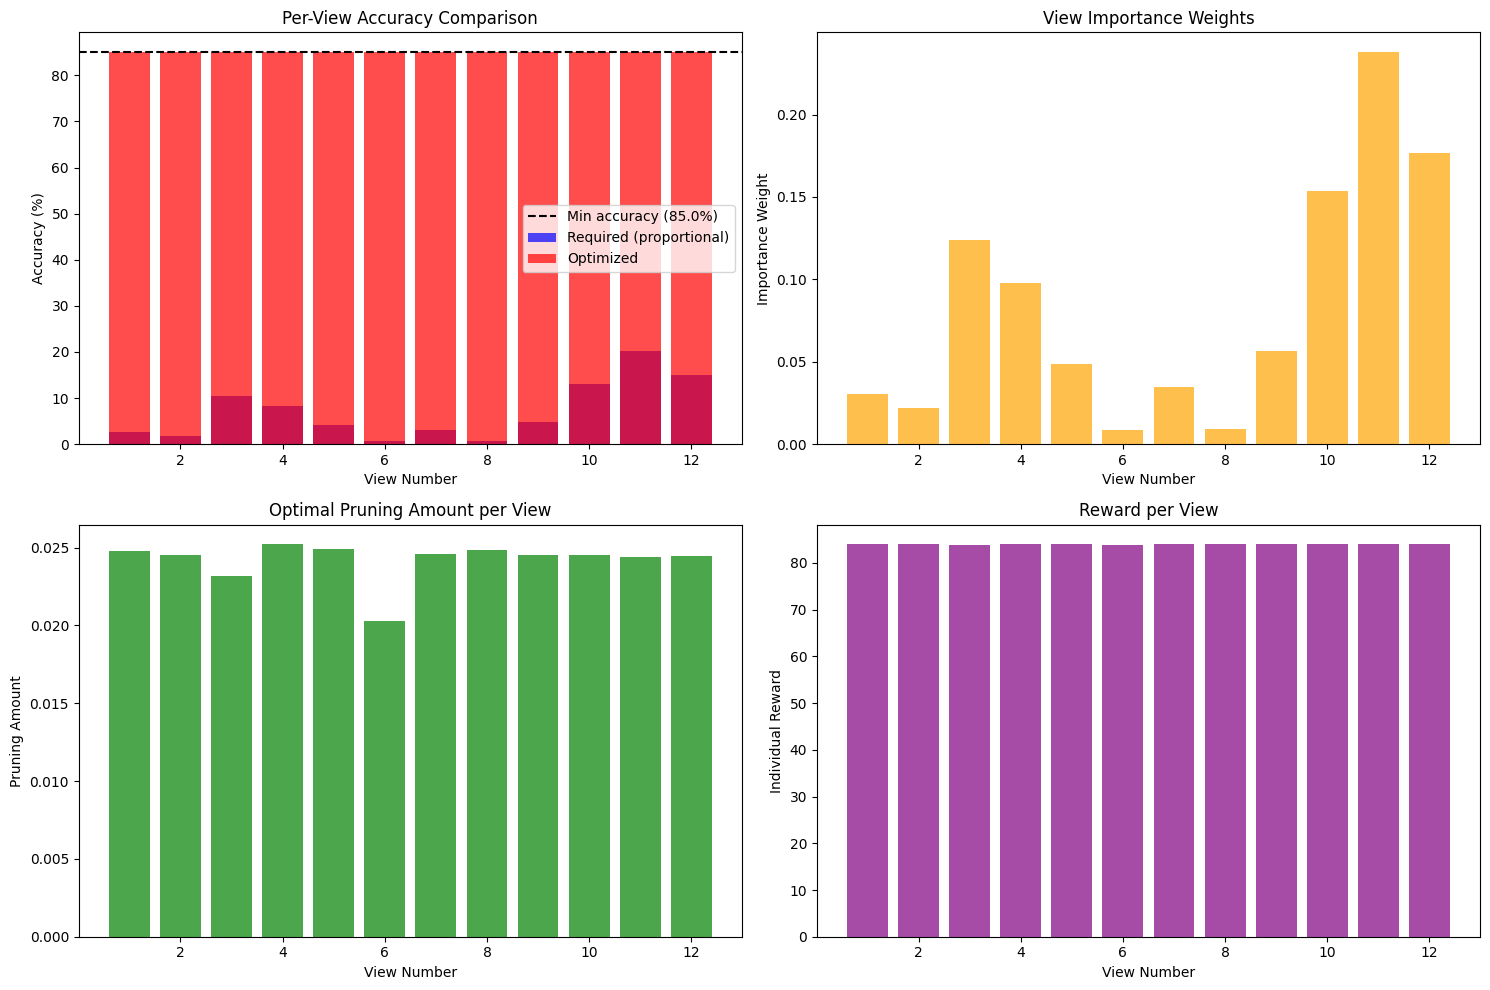


Summary Statistics:
Average per-view accuracy: 85.01%
Minimum per-view accuracy: 85.00%
Maximum per-view accuracy: 85.06%
Standard deviation: 0.01%
Average pruning amount: 0.0242


In [89]:
# Visualize the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Per-view accuracies comparison
views = range(1, 13)
ax1.bar(views, per_view_acc_req, alpha=0.7, label='Required (proportional)', color='blue')
ax1.bar(views, optimal_per_view_accs, alpha=0.7, label='Optimized', color='red')
ax1.axhline(y=min_accuracy, color='black', linestyle='--', label=f'Min accuracy ({min_accuracy}%)')
ax1.set_xlabel('View Number')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Per-View Accuracy Comparison')
ax1.legend()

# Plot 2: Importance weights
ax2.bar(views, i, color='orange', alpha=0.7)
ax2.set_xlabel('View Number')
ax2.set_ylabel('Importance Weight')
ax2.set_title('View Importance Weights')

# Plot 3: Pruning amounts per view
ax3.bar(views, optimal_pruning_amounts, color='green', alpha=0.7)
ax3.set_xlabel('View Number')
ax3.set_ylabel('Pruning Amount')
ax3.set_title('Optimal Pruning Amount per View')

# Plot 4: Individual view rewards
individual_rewards = [get_reward(p, min_accuracy, max_model_size) for p in optimal_pruning_amounts]
ax4.bar(views, individual_rewards, color='purple', alpha=0.7)
ax4.set_xlabel('View Number')
ax4.set_ylabel('Individual Reward')
ax4.set_title('Reward per View')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Average per-view accuracy: {np.mean(optimal_per_view_accs):.2f}%")
print(f"Minimum per-view accuracy: {np.min(optimal_per_view_accs):.2f}%")
print(f"Maximum per-view accuracy: {np.max(optimal_per_view_accs):.2f}%")
print(f"Standard deviation: {np.std(optimal_per_view_accs):.2f}%")
print(f"Average pruning amount: {np.mean(optimal_pruning_amounts):.4f}")

In [ ]:
MAX_MODEL_SIZES = [
    200.0,  # View 0
    180.0,  # View 1
    300.0,  # View 2
    250.0,  # View 3
    220.0,  # View 4
    150.0,  # View 5
    200.0,  # View 6
    180.0,  # View 7
    250.0,  # View 8
    300.0,  # View 9
    400.0,  # View 10
    350.0   # View 11
]

In [ ]:
import numpy as np
import cma

def optimize_target_accuracy_with_individual_constraints(
    min_accuracy=80.0,
    max_model_sizes=None,
    initial_target_acc=85.01
):
    """Use CMA-ES to optimize the target total accuracy that maximizes reward
    while satisfying all per-view accuracy & size constraints."""
    
    if max_model_sizes is None:
        max_model_sizes = [300.0] * 12
    
    # Compute lower‐bound so even the smallest-weighted view meets min_accuracy
    min_target_from_accuracy = min_accuracy / np.min(i)
    if min_target_from_accuracy > 100:
        print(f"Warning: lower‐bound {min_target_from_accuracy:.1f}% > 100%. Relaxing to 80%.")
        min_target_bound = max(initial_target_acc * 0.8, 80.0)
    else:
        min_target_bound = max(min_target_from_accuracy, initial_target_acc * 0.8)
    
    upper_bound = min(120.0, initial_target_acc * 1.5)
    bounds = [min_target_bound, upper_bound]
    print(f"Searching target_total_acc in [{bounds[0]:.2f}%, {bounds[1]:.2f}%]")

    def objective(x):
        T = x[0]  # global target accuracy
        per_view_accs = T * i

        # penalties for min-accuracy or size violations
        total_penalty = 0
        for idx, acc in enumerate(per_view_accs):
            if acc < min_accuracy:
                total_penalty += (min_accuracy - acc)**2 * 1e3
            try:
                p = get_pruning_from_accuracy(acc)
                size = get_size(p)
                if size > max_model_sizes[idx]:
                    total_penalty += (size - max_model_sizes[idx])**2 * 10
            except:
                total_penalty += 1e4

        # aggregate weighted reward
        total_reward = sum(
            get_reward(get_pruning_from_accuracy(acc),
                       min_accuracy,
                       max_model_sizes[idx]) * i[idx]
            for idx, acc in enumerate(per_view_accs)
        )
        return -(total_reward - total_penalty)

    # run CMA-ES for us
    x0, sigma0 = [initial_target_acc], 5.0
    best_sol, best_fit = cma.fmin2(
        objective,
        x0,
        sigma0,
        {
            'bounds':  bounds,
            'popsize': 30,
            'maxiter': 200,
            'tolfun':  1e-6,
        }
    )

    optimal_T = best_sol[0]
    optimal_per_view = optimal_T * i
    actual_reward = max(0.0, -best_fit)

    return optimal_per_view, optimal_T, actual_reward

# Run the corrected optimization
print("Optimizing target accuracy with proportional per-view accuracy assignment...")
print(f"Importance weights: {i}")
print(f"Max model sizes per view: {MAX_MODEL_SIZES}")
print(f"Required: each view gets accuracy = target_total_acc * importance_weight")

result = optimize_target_accuracy_with_individual_constraints(
    min_accuracy=min_accuracy, 
    max_model_sizes=MAX_MODEL_SIZES, 
    initial_target_acc=whole_model_accuracy
)

if result[0] is not None:
    optimal_per_view_accs_corrected, optimal_target_acc, optimal_reward_corrected = result
    
    print(f"\nOptimal target total accuracy: {optimal_target_acc:.2f}%")
    print(f"Optimal per-view accuracies (proportional assignment):")
    for i_view, acc in enumerate(optimal_per_view_accs_corrected):
        print(f"View {i_view + 1}: {acc:.2f}% (= {optimal_target_acc:.2f}% × {i[i_view]:.4f})")

    print(f"\nVerification - Sum of weighted accuracies: {np.sum(optimal_per_view_accs_corrected * i):.2f}%")
    print(f"Should equal target accuracy: {optimal_target_acc:.2f}%")
    print(f"Total reward: {optimal_reward_corrected:.2f}")

    # Calculate corresponding pruning amounts and model sizes
    optimal_pruning_amounts_corrected = [get_pruning_from_accuracy(acc) for acc in optimal_per_view_accs_corrected]
    optimal_model_sizes_corrected = [get_size(p) for p in optimal_pruning_amounts_corrected]

    print(f"\nCorresponding pruning amounts and model sizes:")
    for i_view, (p, size) in enumerate(zip(optimal_pruning_amounts_corrected, optimal_model_sizes_corrected)):
        constraint_met = "✓" if size <= MAX_MODEL_SIZES[i_view] else "✗"
        acc_constraint_met = "✓" if optimal_per_view_accs_corrected[i_view] >= min_accuracy else "✗"
        print(f"View {i_view + 1}: Pruning={p:.4f}, Size={size:.1f} (Max: {MAX_MODEL_SIZES[i_view]:.1f}) {constraint_met}, Acc={optimal_per_view_accs_corrected[i_view]:.1f}% (Min: {min_accuracy}%) {acc_constraint_met}")
else:
    print("Optimization failed. Using fallback solution with original target accuracy.")
    optimal_target_acc = whole_model_accuracy
    optimal_per_view_accs_corrected = optimal_target_acc * i
    optimal_reward_corrected = 0
    optimal_pruning_amounts_corrected = [get_pruning_from_accuracy(acc) for acc in optimal_per_view_accs_corrected]
    optimal_model_sizes_corrected = [get_size(p) for p in optimal_pruning_amounts_corrected]

Optimizing target accuracy with proportional per-view accuracy assignment...
Importance weights: [0.03044561 0.02201545 0.12376647 0.09755174 0.04860051 0.00832497
 0.03501421 0.00934147 0.05674529 0.15345743 0.237974   0.17676284]
Max model sizes per view: [200.0, 180.0, 300.0, 250.0, 220.0, 150.0, 200.0, 180.0, 250.0, 300.0, 400.0, 350.0]
Required: each view gets accuracy = target_total_acc * importance_weight
Searching target_total_acc in [80.00%, 120.00%]
(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 1 (seed=369676, Sat Jul 12 03:22:59 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


    1     30 7.188900826925342e+07 1.0e+00 1.01e+01  1e+01  1e+01 0:00.0


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[85.01].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul 12 03:22:59 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


ValueError: not yet initialized (dimension needed)

In [ ]:
# Enhanced visualization comparing both approaches
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

views = range(1, 13)

# Plot 1: Per-view accuracies comparison
width = 0.25
x = np.arange(len(views))

ax1.bar(x - width, per_view_acc_req, width, alpha=0.7, label='Required (proportional)', color='blue')
ax1.bar(x, optimal_per_view_accs, width, alpha=0.7, label='Optimized (uniform constraints)', color='red')
ax1.bar(x + width, optimal_per_view_accs_corrected, width, alpha=0.7, label='Optimized (individual constraints)', color='green')
ax1.axhline(y=min_accuracy, color='black', linestyle='--', label=f'Min accuracy ({min_accuracy}%)')
ax1.set_xlabel('View Number')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Per-View Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(views)
ax1.legend()

# Plot 2: Model size constraints vs actual sizes
ax2.bar(x - width/2, MAX_MODEL_SIZES, width, alpha=0.7, label='Max allowed size', color='orange')
ax2.bar(x + width/2, optimal_model_sizes_corrected, width, alpha=0.7, label='Actual size', color='purple')
ax2.set_xlabel('View Number')
ax2.set_ylabel('Model Size')
ax2.set_title('Model Size Constraints vs Actual Sizes')
ax2.set_xticks(x)
ax2.set_xticklabels(views)
ax2.legend()

# Plot 3: Pruning amounts comparison
ax3.bar(x - width/2, optimal_pruning_amounts, width, alpha=0.7, label='Uniform constraints', color='red')
ax3.bar(x + width/2, optimal_pruning_amounts_corrected, width, alpha=0.7, label='Individual constraints', color='green')
ax3.set_xlabel('View Number')
ax3.set_ylabel('Pruning Amount')
ax3.set_title('Optimal Pruning Amount Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(views)
ax3.legend()

# Plot 4: Summary metrics
metrics = ['Weighted Acc', 'Total Reward', 'Acc Violations', 'Size Violations']
acc_perfect_metrics = [solutions[0]['weighted_acc'], solutions[0]['total_reward'], 
                      solutions[0]['acc_violations'], solutions[0]['size_violations']]
size_perfect_metrics = [solutions[1]['weighted_acc'], solutions[1]['total_reward'], 
                       solutions[1]['acc_violations'], solutions[1]['size_violations']]
    
x_metrics = np.arange(len(metrics))
ax4.bar(x_metrics - width/2, acc_perfect_metrics, width, alpha=0.7, 
        label='Accuracy-Perfect', color='green')
ax4.bar(x_metrics + width/2, size_perfect_metrics, width, alpha=0.7, 
        label='Size-Perfect', color='blue')
ax4.set_xlabel('Metrics')
ax4.set_ylabel('Values')
ax4.set_title('Solution Metrics Comparison')
ax4.set_xticks(x_metrics)
ax4.set_xticklabels(metrics)
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary table
print(f"\n{'Solution':<20} {'Weighted Acc':<12} {'Total Reward':<12} {'Acc Viol':<10} {'Size Viol':<10}")
print("-" * 70)
for sol in solutions:
    print(f"{sol['name']:<20} {sol['weighted_acc']:<12.2f} {sol['total_reward']:<12.2f} "
          f"{sol['acc_violations']:<10} {sol['size_violations']:<10}")

## Uing NSGA II

In [ ]:
MAX_MODEL_SIZES = [
    200.0,  # View 0
    180.0,  # View 1
    300.0,  # View 2
    250.0,  # View 3
    220.0,  # View 4
    150.0,  # View 5
    200.0,  # View 6
    180.0,  # View 7
    250.0,  # View 8
    300.0,  # View 9
    400.0,  # View 10
    350.0   # View 11
]
min_accuracy = 80.0

In [114]:
i_org = np.array([0.03044561, 0.02201545, 0.12376647, 0.09755174, 0.04860051,
       0.00832497, 0.03501421, 0.00934147, 0.05674529, 0.15345743,
       0.237974  , 0.17676284])

In [115]:
i = i_org

In [116]:
i

array([0.03044561, 0.02201545, 0.12376647, 0.09755174, 0.04860051,
       0.00832497, 0.03501421, 0.00934147, 0.05674529, 0.15345743,
       0.237974  , 0.17676284])

In [ ]:
# Your existing data
MAX_MODEL_SIZES = [
    200.0, 180.0, 300.0, 250.0, 220.0, 150.0,
    200.0, 180.0, 250.0, 300.0, 400.0, 350.0
]

# You need to define your importance weights 'i' - I'll assume equal weights for now
# Replace this with your actual importance weights
# i = np.ones(12) / 12  # Equal weights that sum to 1
print(f"Sum of i: {np.sum(i)}")

GLOBAL_MIN_ACCURACY = 82.0

# Calculate per-view min accuracy required proportional to importance
min_accuracy_per_view = GLOBAL_MIN_ACCURACY * i

# You need to define these functions - I'll create placeholder implementations
def get_accuracy(p):
    """Convert pruning parameter to accuracy percentage"""
    # This is a placeholder - replace with your actual accuracy function
    # Assuming higher p means more pruning, thus lower accuracy
    return 100 * (1 - p) * 0.9  # Example function

def get_size(p):
    """Convert pruning parameter to model size"""
    # This is a placeholder - replace with your actual size function
    # Assuming higher p means more pruning, thus smaller size
    return 100 + 300 * p  # Example function

def get_reward(p, min_acc, max_size):
    """Calculate reward for a pruning parameter"""
    acc = get_accuracy(p)
    size = get_size(p)
    
    # Reward is higher for higher accuracy and smaller size
    acc_reward = max(0, acc - min_acc)
    size_reward = max(0, max_size - size)
    
    return acc_reward + size_reward * 0.1  # Weight size reward less than accuracy


class MultiViewProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=12,
            n_obj=12,
            xl=np.zeros(12),
            xu=np.ones(12)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 12))

        for j in range(12):
            ps = X[:, j]
            vals = np.zeros(pop_size)
            for k, p in enumerate(ps):
                # Use global min accuracy for consistency
                r = get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j])
                weighted_r = r * i[j]
                vals[k] = -weighted_r  # minimize negative reward
            F[:, j] = vals

        out["F"] = F


class SingleObjectiveProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=12,
            n_obj=1,
            xl=np.zeros(12),
            xu=np.ones(12)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 1))

        for k in range(pop_size):
            p_vec = X[k, :]
            total_reward = 0
            penalty = 0
            
            weighted_acc = 0
            for j, p in enumerate(p_vec):
                acc = get_accuracy(p)
                size = get_size(p)
                weighted_acc += acc * i[j]
                
                # Apply penalty for size violations
                if size > MAX_MODEL_SIZES[j]:
                    penalty += (size - MAX_MODEL_SIZES[j]) ** 2 * 100  # Increased penalty
                
                r = get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j])
                total_reward += r * i[j]

            # Strong penalty if weighted accuracy below global min accuracy
            if weighted_acc < GLOBAL_MIN_ACCURACY:
                penalty += (GLOBAL_MIN_ACCURACY - weighted_acc) ** 2 * 10000  # Much stronger penalty
            
            F[k, 0] = -(total_reward - penalty)

        out["F"] = F


def is_feasible_corrected(p_vec):
    accs = np.array([get_accuracy(p) for p in p_vec])
    sizes = np.array([get_size(p) for p in p_vec])
    weighted_acc = np.sum(accs * i)
    
    # Check global accuracy constraint
    if weighted_acc < GLOBAL_MIN_ACCURACY:
        return False, accs, sizes
    
    # Check size constraints
    if np.any(sizes > MAX_MODEL_SIZES):
        return False, accs, sizes
    
    return True, accs, sizes


def relax_constraints_progressively():
    """Progressively relax constraints to find feasible solutions"""
    print("\n" + "="*60)
    print("PROGRESSIVE CONSTRAINT RELAXATION")
    print("="*60)
    
    relaxation_scenarios = [
        {"acc_relax": 0, "size_relax": 1.0, "desc": "Original constraints"},
        {"acc_relax": 2, "size_relax": 1.05, "desc": "Relax accuracy by 2%, size by 5%"},
        {"acc_relax": 5, "size_relax": 1.1, "desc": "Relax accuracy by 5%, size by 10%"},
        {"acc_relax": 8, "size_relax": 1.15, "desc": "Relax accuracy by 8%, size by 15%"},
        {"acc_relax": 10, "size_relax": 1.2, "desc": "Relax accuracy by 10%, size by 20%"},
    ]
    
    for scenario in relaxation_scenarios:
        print(f"\n--- {scenario['desc']} ---")
        
        # Temporarily adjust constraints
        relaxed_min_acc = GLOBAL_MIN_ACCURACY - scenario['acc_relax']
        relaxed_max_sizes = [size * scenario['size_relax'] for size in MAX_MODEL_SIZES]
        
        print(f"Target accuracy: {relaxed_min_acc:.1f}%")
        print(f"Max sizes: {np.round(relaxed_max_sizes, 1)}")
        
        # Test feasibility with relaxed constraints
        feasible_count = 0
        best_solution = None
        best_weighted_acc = 0
        
        for trial in range(500):  # Quick feasibility test
            p_vec = np.random.beta(2, 8, 12)
            accs = np.array([get_accuracy(p) for p in p_vec])
            sizes = np.array([get_size(p) for p in p_vec])
            weighted_acc = np.sum(accs * i)
            
            # Check relaxed constraints
            acc_feasible = weighted_acc >= relaxed_min_acc
            size_feasible = np.all(sizes <= relaxed_max_sizes)
            
            if acc_feasible and size_feasible:
                feasible_count += 1
                if weighted_acc > best_weighted_acc:
                    best_weighted_acc = weighted_acc
                    best_solution = (p_vec, accs, sizes, weighted_acc)
        
        print(f"Feasible solutions found: {feasible_count}/500 ({feasible_count/5:.1f}%)")
        
        if feasible_count > 0:
            print(f"Best weighted accuracy found: {best_weighted_acc:.2f}%")
            
            # If we found feasible solutions, run optimization with relaxed constraints
            if feasible_count >= 10:  # If reasonably feasible
                print("Running optimization with relaxed constraints...")
                result = optimize_with_relaxed_constraints(relaxed_min_acc, relaxed_max_sizes)
                return result
        else:
            print("No feasible solutions found with these constraints.")
    
    print("\nEven with maximum relaxation, no feasible solutions found.")
    print("Constraints may be fundamentally incompatible.")
    return None


def optimize_with_relaxed_constraints(min_acc, max_sizes):
    """Optimize with relaxed constraints"""
    
    class RelaxedSingleObjectiveProblem(Problem):
        def __init__(self):
            super().__init__(
                n_var=12,
                n_obj=1,
                xl=np.zeros(12),
                xu=np.ones(12)
            )

        def _evaluate(self, X, out, *args, **kwargs):
            pop_size, _ = X.shape
            F = np.zeros((pop_size, 1))

            for k in range(pop_size):
                p_vec = X[k, :]
                total_reward = 0
                penalty = 0
                
                weighted_acc = 0
                for j, p in enumerate(p_vec):
                    acc = get_accuracy(p)
                    size = get_size(p)
                    weighted_acc += acc * i[j]
                    
                    # Apply penalty for size violations
                    if size > max_sizes[j]:
                        penalty += (size - max_sizes[j]) ** 2 * 100
                    
                    r = get_reward(p, min_acc, max_sizes[j])
                    total_reward += r * i[j]

                # Penalty if weighted accuracy below relaxed min accuracy
                if weighted_acc < min_acc:
                    penalty += (min_acc - weighted_acc) ** 2 * 5000
                
                F[k, 0] = -(total_reward - penalty)

            out["F"] = F
    
    # Run optimization with relaxed constraints
    problem = RelaxedSingleObjectiveProblem()
    algorithm = GA(pop_size=200)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 500),
        verbose=False
    )
    
    best_p_vec = res.X
    accs = np.array([get_accuracy(p) for p in best_p_vec])
    sizes = np.array([get_size(p) for p in best_p_vec])
    weighted_acc = np.sum(accs * i)
    
    # Check against relaxed constraints
    acc_feasible = weighted_acc >= min_acc
    size_feasible = np.all(sizes <= max_sizes)
    
    print(f"\n✦ RELAXED OPTIMIZATION RESULT:")
    print("p values:         ", np.round(best_p_vec, 3))
    print("view accuracies %:", np.round(accs, 2))
    print("weighted acc %:   ", np.round(weighted_acc, 2))
    print("model sizes:      ", np.round(sizes, 1))
    print("relaxed max sizes:", np.round(max_sizes, 1))
    print("original max sizes:", np.round(MAX_MODEL_SIZES, 1))
    
    if acc_feasible and size_feasible:
        print("✅ FEASIBLE with relaxed constraints!")
        total_r = sum(get_reward(p, min_acc, max_sizes[j]) * i[j] for j, p in enumerate(best_p_vec))
        print("total reward:     ", np.round(total_r, 2))
        return best_p_vec, accs, sizes, weighted_acc, total_r
    else:
        print("❌ Still infeasible even with relaxed constraints")
        
        # Show violations
        if not acc_feasible:
            print(f"Accuracy violation: {weighted_acc:.2f}% < {min_acc:.2f}%")
        
        if not size_feasible:
            violations = [(j, size, max_sizes[j]) for j, size in enumerate(sizes) if size > max_sizes[j]]
            print(f"Size violations: {len(violations)}")
            for j, size, max_size in violations[:5]:  # Show first 5
                print(f"  View {j+1}: {size:.1f} > {max_size:.1f}")
        
        return best_p_vec, accs, sizes, weighted_acc, None


def optimize_pruning():
    print("Running multi-objective optimization (NSGA-II)...")
    problem = MultiViewProblem()
    algorithm = NSGA2(pop_size=500)  # Increased population size

    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 1000),  # Increased generations
        verbose=False
    )

    pareto_ps = res.X

    feasible = []
    for p_vec in pareto_ps:
        valid, accs, sizes = is_feasible_corrected(p_vec)
        if valid:
            feasible.append((p_vec, accs, sizes))

    if feasible:
        best = None
        best_reward = -np.inf
        for p_vec, accs, sizes in feasible:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(p_vec))
            if total_r > best_reward:
                best_reward = total_r
                best = (p_vec, accs, sizes, total_r)

        p_vec, accs, sizes, total_r = best
        weighted_acc = np.sum(accs * i)

        print("\n✦ FEASIBLE solution found with NSGA-II:")
        print("i values:        ", np.round(i, 3))
        print("p values:         ", np.round(p_vec, 3))
        print("view accuracies %:", np.round(accs, 2))
        print("weighted acc %:   ", np.round(weighted_acc, 2))
        print("model sizes:      ", np.round(sizes, 1))
        print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
        print("total reward:     ", np.round(total_r, 2))

        return p_vec, accs, sizes, weighted_acc, total_r

    else:
        print("\nNo feasible solution found with NSGA-II. Trying single-objective optimization...")
        single_problem = SingleObjectiveProblem()
        single_algorithm = GA(pop_size=200)  # Increased population size

        single_res = minimize(
            single_problem,
            single_algorithm,
            termination=('n_gen', 1000),  # Increased generations
            verbose=False
        )

        best_p_vec = single_res.X
        valid, accs, sizes = is_feasible_corrected(best_p_vec)

        accs = np.array([get_accuracy(p) for p in best_p_vec])
        sizes = np.array([get_size(p) for p in best_p_vec])
        weighted_acc = np.sum(accs * i)

        if valid:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(best_p_vec))

            print("\n✦ FEASIBLE solution found with single-objective GA:")
            print("p values:         ", np.round(best_p_vec, 3))
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
            print("total reward:     ", np.round(total_r, 2))
            return best_p_vec, accs, sizes, weighted_acc, total_r
        else:
            print("\n✦ Best compromise solution (may violate some constraints):")
            print("p values:         ", np.round(best_p_vec, 3))
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))

            # Check constraint violations
            if weighted_acc < GLOBAL_MIN_ACCURACY:
                print(f"\nGlobal accuracy violation: {weighted_acc:.2f}% < {GLOBAL_MIN_ACCURACY}%")

            if size_violations := [
                (j, size, MAX_MODEL_SIZES[j])
                for j, size in enumerate(sizes)
                if size > MAX_MODEL_SIZES[j]
            ]:
                print("\nSize violations:")
                for j, size, max_size in size_violations:
                    print(f"  View {j+1}: {size:.1f} > {max_size}")

            print("\n" + "="*60)
            print("STARTING PROGRESSIVE CONSTRAINT RELAXATION...")
            print("="*60)

            # Try progressive relaxation
            relaxation_result = relax_constraints_progressively()
            if relaxation_result is not None:
                return relaxation_result

            return best_p_vec, accs, sizes, weighted_acc, None


# Additional helper function to find feasible starting points
def find_feasible_starting_point():
    """Find a feasible starting point by working backwards from constraints"""
    print("Searching for feasible starting point...")
    
    # Start with p values that give high accuracy but might violate size constraints
    best_p = None
    best_weighted_acc = 0
    
    for _ in range(1000):
        # Generate random p values, biased towards lower pruning (higher accuracy)
        p_vec = np.random.beta(2, 8, 12)  # Biased towards lower values
        
        accs = np.array([get_accuracy(p) for p in p_vec])
        sizes = np.array([get_size(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        
        # Check if this meets the global accuracy constraint
        if weighted_acc >= GLOBAL_MIN_ACCURACY:
            # Check size constraints
            if np.all(sizes <= MAX_MODEL_SIZES):
                print(f"Found feasible starting point! Weighted accuracy: {weighted_acc:.2f}%")
                return p_vec, accs, sizes, weighted_acc
            else:
                # Track best accuracy even if size constraints are violated
                if weighted_acc > best_weighted_acc:
                    best_weighted_acc = weighted_acc
                    best_p = p_vec
    
    if best_p is not None:
        accs = np.array([get_accuracy(p) for p in best_p])
        sizes = np.array([get_size(p) for p in best_p])
        print(f"Best found: Weighted accuracy: {best_weighted_acc:.2f}% (meets global min)")
        return best_p, accs, sizes, best_weighted_acc
    else:
        print("No feasible starting point found - constraints may be too tight")
        return None, None, None, None


# Test feasibility first
print("Testing feasibility of constraints...")
test_result = find_feasible_starting_point()
if test_result[0] is not None:
    print("Constraints appear feasible. Running optimization...")
    result = optimize_pruning()
else:
    print("Constraints appear infeasible. Consider relaxing them.")

Sum of i: 0.9999999900000001
Testing feasibility of constraints...
Searching for feasible starting point...
Best found: Weighted accuracy: 83.51% (meets global min)
Constraints appear feasible. Running optimization...
Running multi-objective optimization (NSGA-II)...

✦ FEASIBLE solution found with NSGA-II:
i values:         [0.03  0.022 0.124 0.098 0.049 0.008 0.035 0.009 0.057 0.153 0.238 0.177]
p values:          [0.313 0.03  0.08  0.045 0.328 0.032 0.092 0.08  0.1   0.009 0.01  0.003]
view accuracies %: [61.8  87.26 82.8  85.99 60.44 87.15 81.7  82.78 81.01 89.15 89.09 89.69]
weighted acc %:    85.07
model sizes:       [194.  109.1 124.  113.4 198.5 109.5 127.7 124.1 130.  102.8 103.  101. ]
max sizes:         [200. 180. 300. 250. 220. 150. 200. 180. 250. 300. 400. 350.]
total reward:      24.1


In [228]:
i = np.array([0.03044561, 0.02201545, 0.12376647, 0.09755174, 0.04860051,
       0.00832497, 0.03501421, 0.00934147, 0.05674529, 0.15345743,
       0.237974  , 0.17676284])
MAX_MODEL_SIZES = [
    100.0, # View 1
    180.0, # View 2
    140.0, # View 3
    140.0, # View 4
    150.0, # View 5
    90.0, # View 6
    140.0, # View 7
    150.0, # View 8
    170.0, # View 9
    160.0, # View 10
    200.0, # View 11
    250.0, # View 12
]
GLOBAL_MIN_ACCURACY = 70.0

In [229]:
def find_feasible_starting_point():
    """Find a feasible starting point by working backwards from constraints"""
    print("Searching for feasible starting point...")
    
    # Start with p values that give high accuracy but might violate size constraints
    best_p = None
    best_weighted_acc = 0
    
    for _ in range(1000):
        # Generate random p values, biased towards lower pruning (higher accuracy)
        p_vec = np.random.beta(2, 8, 12)  # Biased towards lower values
        
        accs = np.array([get_accuracy(p) for p in p_vec])
        sizes = np.array([get_size(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        
        # Check if this meets the global accuracy constraint
        if weighted_acc >= GLOBAL_MIN_ACCURACY:
            # Check size constraints
            if np.all(sizes <= MAX_MODEL_SIZES):
                print(f"Found feasible starting point! Weighted accuracy: {weighted_acc:.2f}%")
                return p_vec, accs, sizes, weighted_acc
            else:
                # Track best accuracy even if size constraints are violated
                if weighted_acc > best_weighted_acc:
                    best_weighted_acc = weighted_acc
                    best_p = p_vec
    
    if best_p is not None:
        accs = np.array([get_accuracy(p) for p in best_p])
        sizes = np.array([get_size(p) for p in best_p])
        print(f"Best found: Weighted accuracy: {best_weighted_acc:.2f}% (meets global min)")
        return best_p, accs, sizes, best_weighted_acc
    else:
        print("No feasible starting point found - constraints may be too tight")
        return None, None, None, None

def redistribute_accuracy_loss(p_vec, violating_views, target_sizes, i, GLOBAL_MIN_ACCURACY):
    # sourcery skip: low-code-quality
    """
    Redistribute accuracy loss when some views violate size constraints.
    
    Args:
        p_vec: Current pruning vector
        violating_views: List of view indices that violate size constraints
        target_sizes: Target sizes for violating views (their max allowed sizes)
        i: Importance weights
        global_min_accuracy: Global minimum accuracy constraint
    
    Returns:
        new_p_vec: Adjusted pruning vector
        success: Whether redistribution was successful
    """
    new_p_vec = p_vec.copy()

    # Calculate current weighted accuracy
    current_accs = np.array([get_accuracy(p) for p in p_vec])
    current_weighted_acc = np.sum(current_accs * i)

    # Calculate required pruning for violating views to meet size constraints
    total_accuracy_loss = 0

    for view_idx in violating_views:
        target_size = target_sizes[view_idx]

        # Find pruning amount that gives the target size
        # Use binary search to find p that gives size <= target_size
        p_low, p_high = 0.0, 1.0
        best_p = p_vec[view_idx]

        for _ in range(50):  # Binary search iterations
            p_mid = (p_low + p_high) / 2
            size_mid = get_size(p_mid)

            if size_mid <= target_size:
                best_p = p_mid
                p_high = p_mid
            else:
                p_low = p_mid

            if abs(p_high - p_low) < 1e-6:
                break

        # Calculate accuracy loss for this view
        old_acc = get_accuracy(p_vec[view_idx])
        new_acc = get_accuracy(best_p)
        acc_loss = old_acc - new_acc

        # Weight the accuracy loss by importance
        weighted_acc_loss = acc_loss * i[view_idx]
        total_accuracy_loss += weighted_acc_loss

        # Update pruning for this view
        new_p_vec[view_idx] = best_p

        print(f"View {view_idx+1}: Adjusted pruning from {p_vec[view_idx]:.4f} to {best_p:.4f}")
        print(f"  Size: {get_size(p_vec[view_idx]):.1f} → {get_size(best_p):.1f} (max: {target_size:.1f})")
        print(f"  Accuracy: {old_acc:.2f}% → {new_acc:.2f}% (loss: {acc_loss:.2f}%)")
        print(f"  Weighted loss: {weighted_acc_loss:.2f}%")

    print(f"\nTotal weighted accuracy loss: {total_accuracy_loss:.2f}%")

    # Redistribute the accuracy loss among non-violating views
    non_violating_views = [i for i in range(12) if i not in violating_views]

    if not non_violating_views:
        print("All views violate size constraints - cannot redistribute")
        return new_p_vec, False

    # Calculate how much we need to recover in weighted accuracy
    new_weighted_acc = np.sum([get_accuracy(new_p_vec[j]) * i[j] for j in range(12)])
    accuracy_deficit = GLOBAL_MIN_ACCURACY - new_weighted_acc

    print(f"New weighted accuracy after size adjustments: {new_weighted_acc:.2f}%")
    print(f"Required global minimum: {GLOBAL_MIN_ACCURACY:.2f}%")
    print(f"Accuracy deficit to recover: {accuracy_deficit:.2f}%")

    if accuracy_deficit <= 0:
        print("No redistribution needed - global constraint already satisfied")
        return new_p_vec, True

    # Try to recover the deficit by reducing pruning in non-violating views
    print(f"\nRedistributing {accuracy_deficit:.2f}% accuracy deficit among {len(non_violating_views)} views...")

    # Sort non-violating views by their ability to improve (lower current pruning = more room to improve)
    view_flexibility = [(j, new_p_vec[j]) for j in non_violating_views]
    view_flexibility.sort(key=lambda x: x[1])  # Sort by current pruning (ascending)

    remaining_deficit = accuracy_deficit

    for view_idx, current_p in view_flexibility:
        if remaining_deficit <= 0:
            break

        # Calculate how much this view can contribute
        # Try reducing pruning to improve accuracy
        min_p = 0.0
        max_improvement_p = current_p

        if max_improvement_p >= min_p:
            # Calculate potential accuracy improvement
            current_acc = get_accuracy(current_p)
            improved_acc = get_accuracy(max_improvement_p)
            potential_improvement = (improved_acc - current_acc) * i[view_idx]

            # Take what we need or what's available, whichever is smaller
            if potential_improvement > 0:
                # Calculate exact pruning needed for this view's contribution
                needed_acc_improvement = min(remaining_deficit / i[view_idx], improved_acc - current_acc)

                # Find pruning that gives this accuracy improvement
                target_acc = current_acc + needed_acc_improvement

                # Binary search for pruning that gives target accuracy
                p_low, p_high = 0, current_p
                best_p = current_p

                for _ in range(50):
                    p_mid = (p_low + p_high) / 2
                    acc_mid = get_accuracy(p_mid)

                    if acc_mid >= target_acc:
                        best_p = p_mid
                        p_high = p_mid
                    else:
                        p_low = p_mid

                    if abs(p_high - p_low) < 1e-6:
                        break

                # Check if this adjustment violates size constraint
                new_size = get_size(best_p)
                if new_size <= MAX_MODEL_SIZES[view_idx]:
                    actual_improvement = (get_accuracy(best_p) - current_acc) * i[view_idx]
                    new_p_vec[view_idx] = best_p
                    remaining_deficit -= actual_improvement

                    print(f"View {view_idx+1}: Reduced pruning from {current_p:.4f} to {best_p:.4f}")
                    print(f"  Accuracy: {current_acc:.2f}% → {get_accuracy(best_p):.2f}%")
                    print(f"  Weighted contribution: {actual_improvement:.2f}%")
                    print(f"  Size: {get_size(current_p):.1f} → {new_size:.1f} (max: {MAX_MODEL_SIZES[view_idx]:.1f})")
                else:
                    print(f"View {view_idx+1}: Cannot reduce pruning further without violating size constraint")

    # Check final result
    final_weighted_acc = np.sum([get_accuracy(new_p_vec[j]) * i[j] for j in range(12)])
    final_success = final_weighted_acc >= GLOBAL_MIN_ACCURACY

    print(f"\n{'='*50}")
    print("REDISTRIBUTION RESULT:")
    print(f"Final weighted accuracy: {final_weighted_acc:.2f}%")
    print(f"Global minimum required: {GLOBAL_MIN_ACCURACY:.2f}%")
    print(f"Success: {"Y" if final_success else 'N'}")

    if not final_success:
        print(f"Remaining deficit: {GLOBAL_MIN_ACCURACY - final_weighted_acc:.2f}%")

    return new_p_vec, final_success


def handle_size_violations(p_vec, i, global_min_accuracy, MAX_MODEL_SIZES):
    """
    Handle size constraint violations by adjusting pruning and redistributing accuracy loss.
    
    Args:
        p_vec: Current pruning vector
        i: Importance weights
        global_min_accuracy: Global minimum accuracy constraint
        max_model_sizes: Maximum allowed sizes per view
    
    Returns:
        adjusted_p_vec: Adjusted pruning vector
        success: Whether adjustment was successful
        final_metrics: Dictionary with final metrics
    """
    print("\n" + "="*60)
    print("HANDLING SIZE CONSTRAINT VIOLATIONS")
    print("="*60)

    # Identify violating views
    current_sizes = np.array([get_size(p) for p in p_vec])
    violating_views = [i for i, size in enumerate(current_sizes) if size > MAX_MODEL_SIZES[i]]

    if not violating_views:
        print("No size violations detected.")
        accs = np.array([get_accuracy(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        return p_vec, True, {
            'weighted_accuracy': weighted_acc,
            'view_accuracies': accs,
            'view_sizes': current_sizes,
            'violations': []
        }

    print(f"Found {len(violating_views)} views violating size constraints:")
    for view_idx in violating_views:
        print(f"  View {view_idx+1}: {current_sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}")

    # Redistribute accuracy loss
    adjusted_p_vec, success = redistribute_accuracy_loss(
        p_vec, violating_views, MAX_MODEL_SIZES, i, global_min_accuracy
    )

    # Calculate final metrics
    final_accs = np.array([get_accuracy(p) for p in adjusted_p_vec])
    final_sizes = np.array([get_size(p) for p in adjusted_p_vec])
    final_weighted_acc = np.sum(final_accs * i)

    remaining_violations = [
        {
            'view': j + 1,
            'size': final_sizes[j],
            'max_size': MAX_MODEL_SIZES[j],
            'violation': final_sizes[j] - MAX_MODEL_SIZES[j],
        }
        for j in range(12)
        if final_sizes[j] > MAX_MODEL_SIZES[j]
    ]
    final_metrics = {
        'weighted_accuracy': final_weighted_acc,
        'view_accuracies': final_accs,
        'view_sizes': final_sizes,
        'violations': remaining_violations,
        'global_constraint_met': final_weighted_acc >= global_min_accuracy
    }

    return adjusted_p_vec, success and not remaining_violations, final_metrics


# Modified optimization function that uses the redistribution
def optimize_pruning_with_redistribution():
    """Enhanced optimization that handles size violations through redistribution"""
    print("Running enhanced optimization with redistribution...")

    # First try standard optimization
    result = optimize_pruning()

    if result is None:
        print("Standard optimization failed. Trying redistribution approach...")
        return None

    p_vec, accs, sizes, weighted_acc, total_r = result

    # Fix: Use proper variable names to avoid conflicts
    size_violations = [view_idx for view_idx, size in enumerate(sizes) if size > MAX_MODEL_SIZES[view_idx]]

    if not size_violations:
        print("No size violations - solution is already feasible!")
        return result

    print(f"\nDetected {len(size_violations)} size violations. Applying redistribution...")
    
    # Debug: Print the actual violations
    print("Size violations detected:")
    for view_idx in size_violations:
        print(f"  View {view_idx+1}: {sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}")

    # Apply redistribution
    adjusted_p_vec, success, metrics = handle_size_violations(
        p_vec, i, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES
    )

    if success:
        return successful_redist(adjusted_p_vec, i, metrics, total_r)
    
    print("❌ Redistribution failed - returning original solution with violations")
    return result


def successful_redist(adjusted_p_vec, i, metrics, total_r):
    # Calculate new total reward
    new_total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                     for j, p in enumerate(adjusted_p_vec))

    print("\n✅ SUCCESSFUL REDISTRIBUTION:")
    print("Adjusted p values:    ", np.round(adjusted_p_vec, 3))
    print("View accuracies %:    ", np.round(metrics['view_accuracies'], 4))
    print("Weighted accuracy %:  ", np.round(metrics['weighted_accuracy'], 4))
    print("Model sizes:          ", np.round(metrics['view_sizes'], 2))
    print("Max sizes:            ", np.round(MAX_MODEL_SIZES, 2))
    print("New total reward:     ", np.round(new_total_r, 2))
    print("Original total reward:", np.round(total_r, 2))

    return adjusted_p_vec, metrics['view_accuracies'], metrics['view_sizes'], metrics['weighted_accuracy'], new_total_r

# Test the redistribution approach
print("Testing redistribution approach...")
test_result = find_feasible_starting_point()
if test_result[0] is not None:
    print("Running optimization with redistribution...")
    final_result = optimize_pruning_with_redistribution()
    
    if final_result is not None:
        print("\n🎯 FINAL OPTIMIZED SOLUTION WITH REDISTRIBUTION COMPLETE")
        print("Adjusted p values:    ", np.round(final_result[0], 3))
        print("View accuracies %:    ", np.round(final_result[1], 2))
        print("Weighted accuracy %:  ", np.round(final_result[3], 2))
        print("Required global accuracy: ", GLOBAL_MIN_ACCURACY)
        print("Model sizes:          ", np.round(final_result[2], 1))
        print("Max sizes:            ", np.round(MAX_MODEL_SIZES, 1))
        print("Total reward:         ", np.round(final_result[4], 2))
        
        print(f"{'View':<6} {'Size':<10} {'Max Size':<12} {'Accuracy (%)':<15} {'Importance':<10}, {'Prune':<10}")
        print("-" * 70)

        for view in range(12):
            size = final_result[2][view]
            max_size = MAX_MODEL_SIZES[view]
            acc = final_result[1][view]
            importance = i[view]
            prune = final_result[0][view]
            print(f"{view+1:<6} {size:<10.1f} {max_size:<12.1f} {acc:<15.2f} {importance*100:<10.3f} {prune:<10.3f}")
        print("\n" + "="*70)
        print("Final Weighted Accuracy: ", np.round(final_result[3], 2))
else:
    print("Constraints appear too tight even for redistribution approach.")

Testing redistribution approach...
Searching for feasible starting point...
Best found: Weighted accuracy: 97.56% (meets global min)
Running optimization with redistribution...
Running enhanced optimization with redistribution...

Detected 11 size violations. Applying redistribution...
Size violations detected:
  View 1: 191.8 > 100.0
  View 2: 273.2 > 180.0
  View 3: 231.1 > 140.0
  View 4: 185.9 > 140.0
  View 5: 293.4 > 150.0
  View 6: 227.2 > 90.0
  View 7: 251.1 > 140.0
  View 8: 162.8 > 150.0
  View 9: 229.9 > 170.0
  View 10: 180.7 > 160.0
  View 11: 258.3 > 200.0

HANDLING SIZE CONSTRAINT VIOLATIONS
Found 11 views violating size constraints:
  View 1: 191.8 > 100.0
  View 2: 273.2 > 180.0
  View 3: 231.1 > 140.0
  View 4: 185.9 > 140.0
  View 5: 293.4 > 150.0
  View 6: 227.2 > 90.0
  View 7: 251.1 > 140.0
  View 8: 162.8 > 150.0
  View 9: 229.9 > 170.0
  View 10: 180.7 > 160.0
  View 11: 258.3 > 200.0
View 1: Adjusted pruning from 0.3606 to 0.6667
  Size: 191.8 → 100.0 (max: 10